In [13]:

# change the text here
clip_text = ["Walking forward in an even pace"]
clip_text = ["Going ahead in an even pace"]
clip_text=['A human utilizes his right arm to help himself to stand up.']
clip_text=['A native is stepping ahead briskly.']
clip_text=['A native motions a quarter of a loop to the right.']
import sys
sys.argv = ['GPT_eval_multi.py']
import options.option_transformer as option_trans
args = option_trans.get_args_parser()

args.dataname = 't2m'
args.resume_pth = 'pretrained/VQVAE/net_last.pth'
args.resume_trans = 'pretrained/net_best_fid.pth'
args.clip_path = 'pretrained/clip_best.pth'
args.down_t = 2
args.depth = 3
args.block_size = 51
from PIL import Image

from CLIP.clip import clip
from CLIP.clip import model

import torch
import numpy as np
import models.vqvae as vqvae
import models.t2m_trans as trans
import warnings
warnings.filterwarnings('ignore')

## load clip model and datasets
clip_model, clip_preprocess = clip.load(args.clip_path, device=torch.device('cuda'), jit=False)  # Must set jit=False for training
# clip.model.convert_weights(clip_model)  # Actually this line is unnecessary since clip by default already on float16
clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad = False

net = vqvae.HumanVQVAE(args, ## use args to define different parameters in different quantizers
                       args.nb_code,
                       args.code_dim,
                       args.output_emb_width,
                       args.down_t,
                       args.stride_t,
                       args.width,
                       args.depth,
                       args.dilation_growth_rate)


trans_encoder = trans.Text2Motion_Transformer(num_vq=args.nb_code, 
                                embed_dim=1024, 
                                clip_dim=args.clip_dim, 
                                block_size=args.block_size, 
                                num_layers=9, 
                                n_head=16, 
                                drop_out_rate=args.drop_out_rate, 
                                fc_rate=args.ff_rate)


print ('loading checkpoint from {}'.format(args.resume_pth))
ckpt = torch.load(args.resume_pth, map_location='cpu')
net.load_state_dict(ckpt['net'], strict=True)
net.eval()
net.cuda()

print ('loading transformer checkpoint from {}'.format(args.resume_trans))
ckpt = torch.load(args.resume_trans, map_location='cpu')
trans_encoder.load_state_dict(ckpt['trans'], strict=True)
trans_encoder.eval()
trans_encoder.cuda()

mean = torch.from_numpy(np.load('./checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/mean.npy')).cuda()
std = torch.from_numpy(np.load('./checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/std.npy')).cuda()
# use this code to calculate attention weights
with torch.no_grad():
    # Encode and normalize the search query using CLIP
    text_token = clip.tokenize(clip_text[0]).cuda()
    text_encoded, weight = clip_model.encode_text(text_token)
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)
tokens = clip_text[0].split(" ")
attention_weights = list(weight[-1][0][1+len(tokens)].cpu().numpy())[:2+len(tokens)][1:][:-1]
attention_weights = [float(item) for item in attention_weights]
attention_weights = np.array(attention_weights)
normalized_attention = attention_weights / attention_weights.sum()
# print(normalized_attention)
text = clip.tokenize(clip_text).cuda()
feat_clip_text = clip_model.encode_text(text)[0].float()
index_motion = trans_encoder.sample(feat_clip_text[0:1], False)
attentions = trans_encoder.sample(feat_clip_text[0:1],if_categorial=False,get_att=True)


pred_pose = net.forward_decoder(index_motion)
print(index_motion)
from utils.motion_process import recover_from_ric
pred_xyz = recover_from_ric((pred_pose*std+mean).float(), 22)
xyz = pred_xyz.reshape(1, -1, 22, 3)

np.save('motion.npy', xyz.detach().cpu().numpy())

import visualization.plot_3d_global as plot_3d
pose_vis = plot_3d.draw_to_batch(xyz.detach().cpu().numpy(),clip_text, [f'{clip_text[0]}.gif'])



loading checkpoint from pretrained/VQVAE/net_last.pth
loading transformer checkpoint from D:\project\faithfulpose\T2M-GPT-main\pretrained\net_best_fid.pth
[0.06827529 0.09180064 0.06120043 0.11549855 0.04500877 0.18981335
 0.0412125  0.059935   0.18670731 0.09415893 0.04638923]
tensor([[301, 423, 423, 423, 423, 423, 423, 423, 423, 423, 233, 301,  25, 154,
         176,  44,  39, 239, 364, 468, 367, 147,  10, 234, 173, 173, 173, 361,
         173]], device='cuda:0')



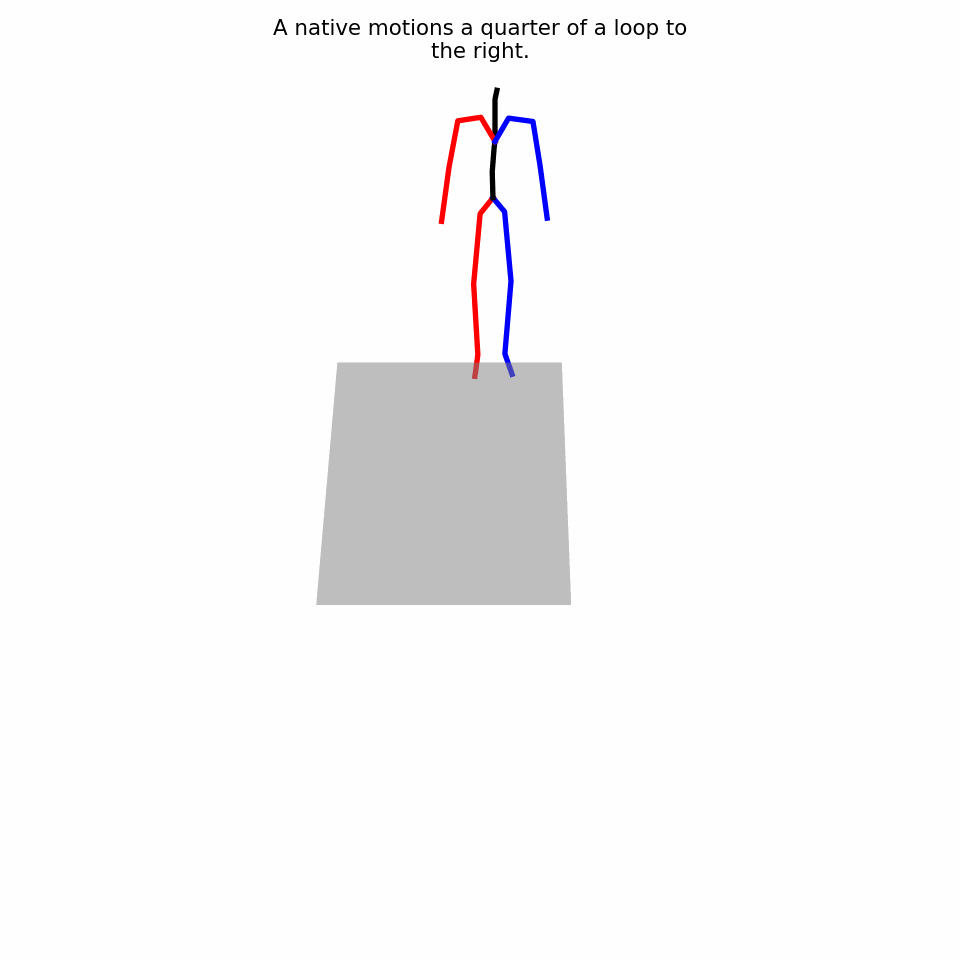

In [14]:
from IPython.display import HTML
import base64
b64 = base64.b64encode(open(f'{clip_text[0]}.gif','rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))